""

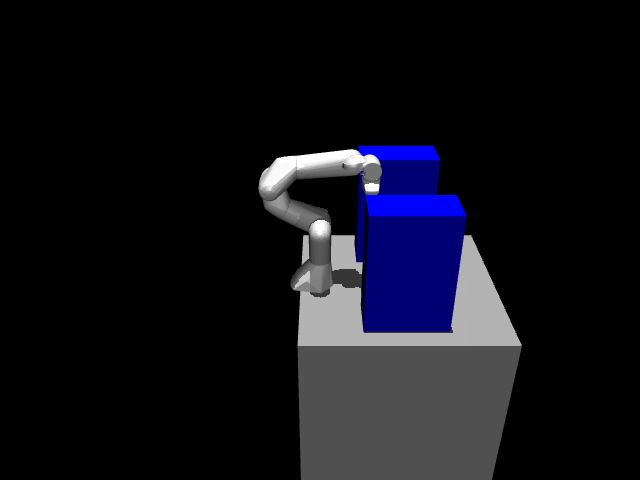

In [3]:
import mujoco
import mediapy as media
import os
import glfw
import numpy as np

def has_valid_renderer():
    """Checks if OpenGL can be initialized successfully."""
    # Try initializing GLFW
    if not glfw.init():
        print("GLFW initialization failed. No valid renderer.")
        return False
    
    # Try creating a hidden window to test OpenGL context creation
    window = glfw.create_window(640, 480, "Renderer Test", None, None)
    if not window:
        print("GLFW could not create an OpenGL context. No valid renderer.")
        glfw.terminate()
        return False
    
    glfw.make_context_current(window)
    renderer_available = True  # If we reach this point, rendering should work

    # Cleanup
    glfw.destroy_window(window)
    glfw.terminate()
    return renderer_available

def render_state(model, data):
    if not has_valid_renderer():
        print("Error rendering the scene. Make sure you have a valid OpenGL installation.")
        return

    mujoco.mj_forward(model, data)
    with mujoco.Renderer(model, height=480, width=640) as renderer:
        renderer.update_scene(data, "front_view")  # Ensure scene is updated with final simulation state
        media.show_image(renderer.render())

def set_joint_positions(model, data, joints):
    joint_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"panda_joint{i+1}") for i in range(7)] # SOLUTION
    joint_qpos_idx = model.jnt_qposadr[joint_ids]
    data.qpos[joint_qpos_idx] = joints
    mujoco.mj_forward(model, data)

def get_joint_positions(model, data):
    joint_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"panda_joint{i+1}") for i in range(7)] # SOLUTION
    joint_qpos_idx = model.jnt_qposadr[joint_ids]
    return data.qpos[joint_qpos_idx]

def get_home_joint_positions(model, data):
    return [0, -np.pi/3, 0, -5*np.pi/6, 0, np.pi/2, np.pi/4]

def get_goal_joint_positions(model, data):
    return [-np.pi/2, np.pi/6, 0, -np.pi/3, np.pi/2, np.pi/2, np.pi/4]
    
# Define the MJCF path and mesh directory
mjcf_path = 'assets/Panda/panda.mjcf'
mesh_dir = 'assets/Panda/meshes/collision/'

# Load mesh files into a dictionary
assets = {}
for file_name in os.listdir(mesh_dir):
    file_path = os.path.join(mesh_dir, file_name)
    with open(file_path, 'rb') as f:
        assets[f'meshes/collision/{file_name}'] = f.read()

# Load the MuJoCo model
model = mujoco.MjModel.from_xml_path(mjcf_path, assets=assets)
data = mujoco.MjData(model)
data.qpos[14:16] = 0.04

# Call mj_forward to initialize the state
mujoco.mj_forward(model, data)

# Set the joint positions
set_joint_positions(model, data, get_home_joint_positions(model, data))

# Render the scene
render_state(model, data)